# UMAP-Aided Outlier Detection
Time to try manifold learning, lol

In [1]:
import os
import random

import h5py
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import sklearn.datasets
from sklearn.neighbors import LocalOutlierFactor
import umap
import umap.plot

/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/users/jzhu118/.conda/envs/GEDI/lib/python3.13/site-packages/numba/np/ufunc/dufunc.py:344: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warni

In [2]:
'''Optional: load the pre-computed scaled data from a .parquet file'''
scaled_df = pd.read_parquet('input_standard_scaled.parquet', engine='pyarrow')
scaled_df

,RH_25,RH_50,RH_75,RH_85,RH_95,RH_100,channel,degrade_flag,delta_time,digital_elevation_model,...,zcross_amp,zcross_localenergy,RH_25 Z Score,RH_50 Z Score,RH_75 Z Score,RH_85 Z Score,RH_95 Z Score,RH_100 Z Score,RH_95_minus_50,Missingness
0,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-1.160313,-0.225547,-1.733653,-1.193618,...,0.185156,-0.211920,-0.261052,-0.219977,-0.205986,-0.204688,-0.209075,-0.235969,-0.157817,-0.842991
1,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-1.160313,-0.225547,-1.733653,-1.193618,...,0.208783,-0.188663,-0.344765,-0.238197,-0.205986,-0.198081,-0.197517,-0.212452,-0.118490,-0.842991
2,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-1.160313,-0.225547,-1.733653,-1.193618,...,0.207195,-0.150200,-0.296300,-0.238197,-0.219014,-0.216249,-0.219189,-0.241195,-0.157817,-0.842991
3,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-1.160313,-0.225547,-1.733653,-1.193618,...,0.231784,-0.122365,-0.296300,-0.238197,-0.213431,-0.209643,-0.209075,-0.221597,-0.139465,-0.842991
4,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-1.160313,-0.225547,-1.733653,-1.193618,...,0.270389,-0.049602,-0.309517,-0.227785,-0.205986,-0.198081,-0.187403,-0.187628,-0.110624,-0.842991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11607182,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,1.733180,-0.225547,1.428969,0.836476,...,2.818989,3.565103,-0.459320,-0.266829,-0.213431,-0.198081,-0.175844,-0.060899,-0.050322,-0.842991
11607183,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,1.733180,-0.225547,1.428969,0.836477,...,2.961269,3.969460,-0.459320,-0.277240,-0.219014,-0.209643,-0.187403,-0.060899,-0.060809,-0.842991
11607184,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,1.733180,-0.225547,1.428969,0.836477,...,2.844775,3.569757,-0.476943,-0.277240,-0.213431,-0.198081,-0.175844,-0.041302,-0.039835,-0.842991
11607185,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,1.733180,-0.225547,1.428969,0.836474,...,2.499454,3.202729,-0.428478,-0.256417,-0.205986,-0.191474,-0.171510,-0.046528,-0.052944,-0.842991


In [ ]:
'''Optional: load the pre-computed PCA data from a .parquet file'''
pca_df = pd.read_parquet('input_pca_standard.parquet', engine='pyarrow')
pca_df

In [3]:
# Define the number of rows you want in your subset.
subset_size = 50000  # Adjust this value as needed

# Create a random subset of the data.
subset_df = scaled_df.sample(n=subset_size)

# Display the shape of the subset to confirm the size.
print("Subset shape:", subset_df.shape)

# Add a unique identifier column (using the index or an explicit counter)
subset_df['unique_id'] = subset_df.index  # or: range(len(subset_df))
print("Unique ID added")

Subset shape: (50000, 85)
Unique ID added


In [4]:
# ============================
# STEP 1: UMAP Dimensionality Reduction
# ============================

# Tunable UMAP Parameters:
umap_n_neighbors = 15       # Number of neighboring points used in local approximations (affects local vs. global structure).
umap_min_dist = 0.1         # Minimum distance between points in the low-dimensional space (controls clustering tightness).
umap_n_components = 2       # Dimensionality of the UMAP embedding (commonly 2 for visualization, can be increased).
umap_metric = 'euclidean'   # Distance metric used in the high-dimensional space (e.g., 'euclidean', 'manhattan', etc.).
umap_random_state = 42      # Random seed for reproducibility (ensures consistent embeddings across runs).

# Initialize the UMAP reducer with the tunable parameters
umap_reducer = umap.UMAP(
    n_neighbors=umap_n_neighbors,
    min_dist=umap_min_dist,
    n_components=umap_n_components,
    metric=umap_metric,
    # random_state=umap_random_state
    n_jobs=-1 # use no seed for parallel processing
)
print("UMAP reducer instantiated")

# Assume scaled_df is your cleaned and scaled Pandas DataFrame.
# Compute the UMAP embedding for the dataset.
embedding = umap_reducer.fit_transform(subset_df.drop(columns=['unique_id']))
print("UMAP reducer fit to data")


# Create a DataFrame for the embedding to facilitate further analysis and plotting.
embedding_df = pd.DataFrame(embedding, columns=[f'UMAP_{i+1}' for i in range(umap_n_components)])
print(f"Embedding has shape {embedding_df.shape}")
embedding_df['unique_id'] = subset_df['unique_id'].values
print("Unique ID added back")

UMAP reducer instantiated
UMAP reducer fit to data
Embedding has shape (50000, 2)
Unique ID added back


In [6]:
# Verify that the unique_id order is preserved
if (embedding_df['unique_id'].reset_index(drop=True) == subset_df['unique_id'].reset_index(drop=True)).all():
    print("Row order is preserved between subset_df and embedding_df.")
else:
    print("Row order does not match!")

Row order is preserved between subset_df and embedding_df.


In [ ]:
# ============================
# ALTERNATIVE: GPU accelerated UMAP
# ============================

from cuml import UMAP as cumlUMAP

umap_n_neighbors = 15
umap_min_dist = 0.1
umap_n_components = 2
umap_metric = 'euclidean'
umap_random_state = 42

gpu_umap = cumlUMAP(
    n_neighbors=umap_n_neighbors,
    min_dist=umap_min_dist,
    n_components=umap_n_components,
    metric=umap_metric,
    random_state=umap_random_state
)

# If you used PCA before, use `reduced_data` instead of `scaled_df`
embedding = gpu_umap.fit_transform(scaled_df)


# Create a DataFrame for the embedding to facilitate further analysis and plotting.
embedding_df = pd.DataFrame(embedding, columns=[f'UMAP_{i+1}' for i in range(umap_n_components)])
print(f"Embedding has shape {embedding_df.shape}")

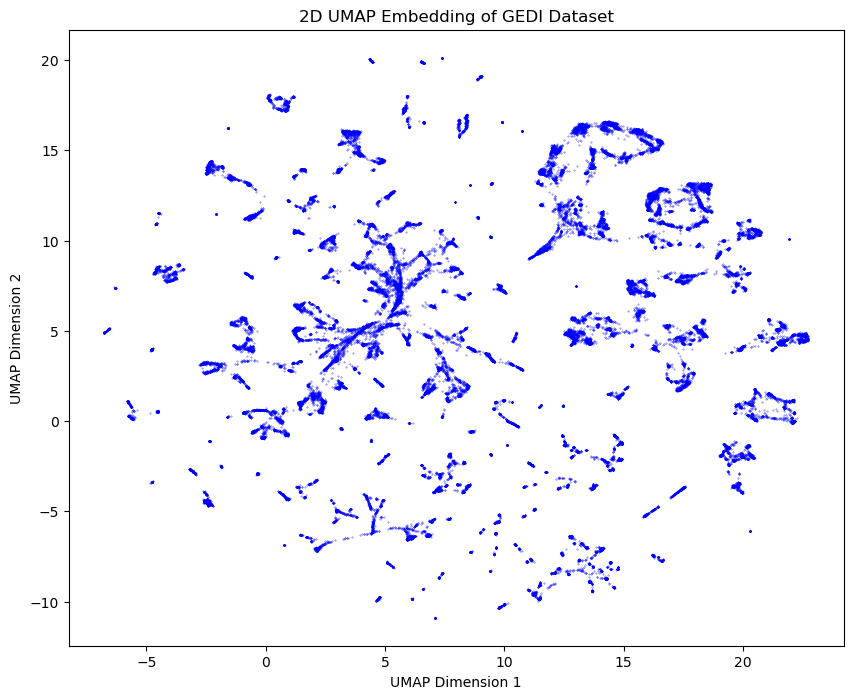

In [9]:
# Plot the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1],
            s=0.1,              # Marker size
            color='blue',       # Uniform color since there are no target labels
            alpha=0.7)          # Transparency to help with overplotting

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('2D UMAP Embedding of GEDI Dataset')
plt.show()

In [7]:
# ============================
# STEP 2: LOF Outlier Detection on the UMAP Embedding
# ============================

# Tunable LOF Parameters:
lof_n_neighbors = 20        # Number of neighbors used to compute the local density (affects sensitivity to outliers).
lof_contamination = 0.05    # The expected proportion of outliers in the dataset (used to set the threshold).
lof_metric = 'euclidean'    # Distance metric used for LOF (should generally match UMAP's metric).
lof_novelty = False         # Whether to enable novelty detection (set False for outlier detection on the training data).

# Initialize the LOF detector with the tunable parameters.
# Note: LOF in sklearn is unsupervised, so by default novelty is False.
lof_detector = LocalOutlierFactor(
    n_neighbors=lof_n_neighbors,
    contamination=lof_contamination,
    metric=lof_metric,
    novelty=lof_novelty
)
print("LOF detector instantiated")

# Fit LOF on the UMAP embedding and obtain outlier predictions.
# The output array, lof_predictions, contains:
#   -1 for outliers and 1 for inliers.
lof_predictions = lof_detector.fit_predict(embedding)
print("LOF predictions generated")

# Append LOF predictions and the negative outlier factor scores to the embedding DataFrame.
embedding_df['LOF_Prediction'] = lof_predictions
embedding_df['LOF_Score'] = lof_detector.negative_outlier_factor_
print("LOF predictions mapped to df")

LOF detector instantiated
LOF predictions generated
LOF predictions mapped to df


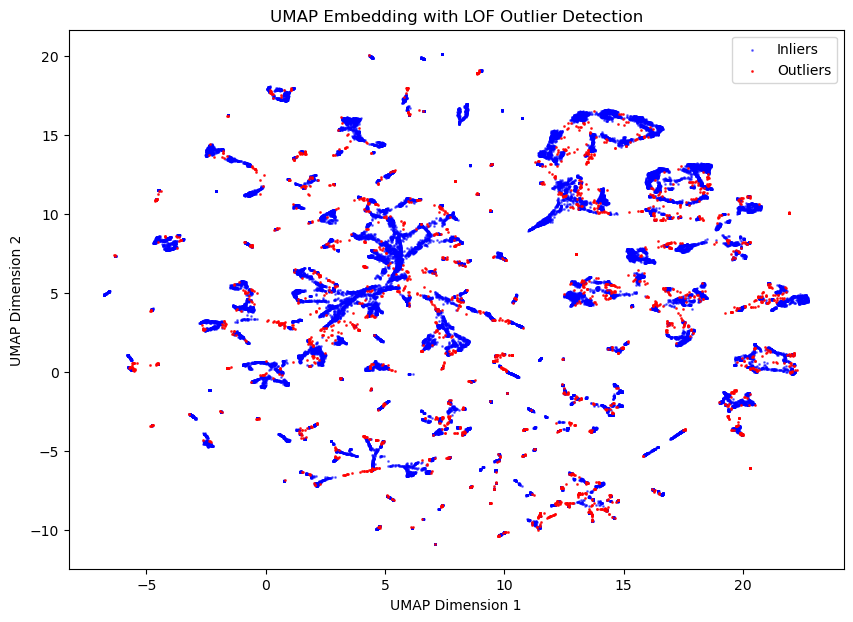

In [8]:
# ============================
# STEP 3: Visualize the Results
# ============================

# Plot the UMAP embedding and highlight detected outliers.
plt.figure(figsize=(10, 7))
# Separate inliers and outliers for plotting
inliers = embedding_df[embedding_df['LOF_Prediction'] == 1]
outliers = embedding_df[embedding_df['LOF_Prediction'] == -1]

plt.scatter(inliers['UMAP_1'], inliers['UMAP_2'], s = 1,
            c='blue', label='Inliers', alpha=0.5)
plt.scatter(outliers['UMAP_1'], outliers['UMAP_2'],  s = 1,
            c='red', label='Outliers', alpha=0.8)

plt.title('UMAP Embedding with LOF Outlier Detection')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

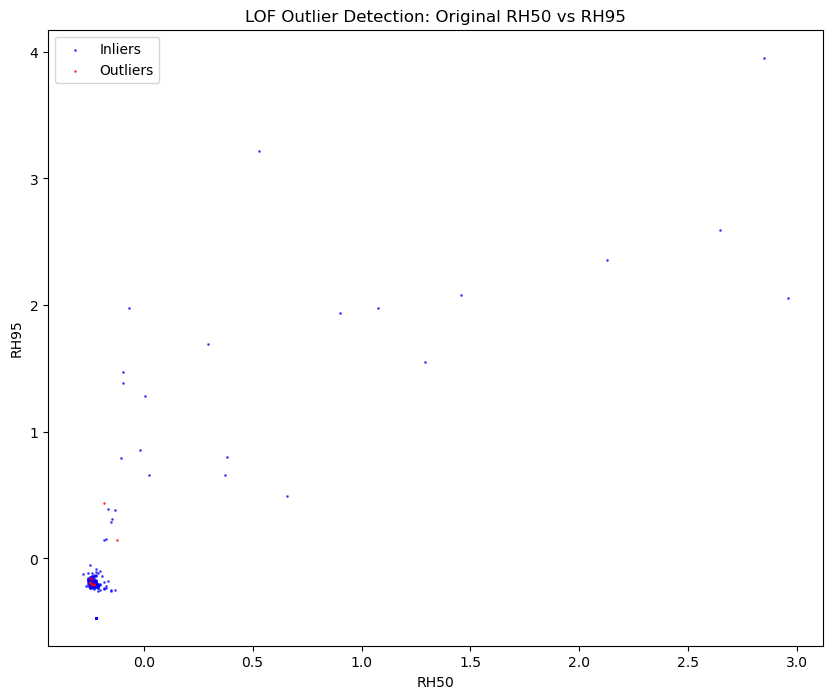

In [10]:
# Merge LOF predictions from the UMAP embedding back into the original subset.
# This assumes that the order of rows in `subset_df` matches the order of rows in `embedding_df`.
subset_df_with_lof = subset_df.copy()
subset_df_with_lof['LOF_Prediction'] = embedding_df['LOF_Prediction']

# Separate inliers and outliers based on LOF predictions.
inliers = subset_df_with_lof[subset_df_with_lof['LOF_Prediction'] == 1]
outliers = subset_df_with_lof[subset_df_with_lof['LOF_Prediction'] == -1]

# Plot the original RH50 vs RH95 space, highlighting the outliers.
plt.figure(figsize=(10, 8))
plt.scatter(inliers['RH_50'], inliers['RH_95'], 
            color='blue', label='Inliers', alpha=0.6, s=1)
plt.scatter(outliers['RH_50'], outliers['RH_95'], 
            color='red', label='Outliers', alpha=0.6, s=1)

plt.xlabel('RH50')
plt.ylabel('RH95')
plt.title('LOF Outlier Detection: Original RH50 vs RH95')
plt.legend()
plt.show()